In [3]:
!pip install wfdb

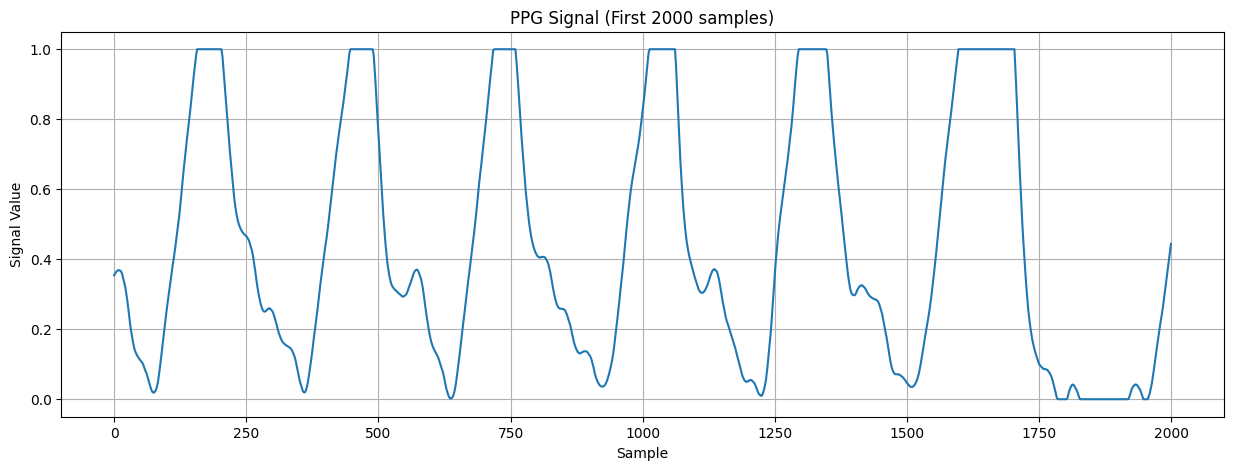

In [8]:
# 필요한 라이브러리를 불러옵니다.
import wfdb
import matplotlib.pyplot as plt

# rdsamp()는 (신호 데이터, 설명 데이터)를 반환합니다.
# 첫 번째 값인 신호 데이터를 'signals' 변수에 바로 저장합니다.
signals, fields = wfdb.rdsamp('bidmc01')

# signals 변수에 이미 데이터가 있으니, 그래프를 바로 그립니다.
# 데이터가 너무 많으니 앞부분 2000개만 잘라서 확인해봅시다.
plt.figure(figsize=(15, 5))
plt.plot(signals[:2000, 0])
plt.title("PPG Signal (First 2000 samples)")
plt.xlabel("Sample")
plt.ylabel("Signal Value")
plt.grid(True)
plt.show()